In [292]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pylab as plt
import seaborn as sns

In [293]:
users = pd.read_csv('takehome_users.csv', index_col=0)
users.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
object_id,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [294]:
engagement = pd.read_csv('takehome_user_engagement.csv', parse_dates=['time_stamp'])
print(engagement.dtypes)
engagement.head()

time_stamp    datetime64[ns]
user_id                int64
visited                int64
dtype: object


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [295]:
#note visited is only ever a 1 so don't need to worry about summing number of visits
engagement.describe()

,time_stamp,user_id,visited
count,207917,207917.000000,207917.0
mean,2013-10-30 05:06:45.648763648,5913.314197,1.0
min,2012-05-31 08:20:06,1.000000,1.0
25%,2013-07-16 20:17:21,3087.000000,1.0
50%,2013-12-03 06:38:34,5682.000000,1.0
75%,2014-03-13 08:00:24,8944.000000,1.0
max,2014-06-06 14:58:50,12000.000000,1.0
std,NaN,3394.941674,0.0


In [296]:
# check for duplicate visits on a single day
engagement['date'] = pd.to_datetime(engagement['time_stamp']).dt.date
engagement.head()

engagement.groupby(['date', 'user_id']).count().describe()

# no duplicates, so we can drop timestamp and just use day

,time_stamp,visited
count,207917.0,207917.0
mean,1.0,1.0
std,0.0,0.0
min,1.0,1.0
25%,1.0,1.0
50%,1.0,1.0
75%,1.0,1.0
max,1.0,1.0


#### Calculate Adopted User
First insolte data for each user
Resample data to daily, ffill, don't fill nas
Compute rolling sum of visted column with 7 day window
Any users with 3 or more visits in 7-day window is an adopted user (add to users table)

In [365]:
# calculate adopted users
for uid in engagement['user_id'].unique(): #for each user
    # user data
    this_user = engagement.loc[engagement['user_id']==uid]
    this_user.index = this_user['time_stamp']
    #resample data so all days are in index
    this_user_resample = this_user.resample('1d').ffill(limit=1)
    # take 7-day rolling sum
    this_user_resample['7-day']= this_user_resample['visited'].rolling(dt.timedelta(days=7), center=True, ).sum()
    #drop na values (back to original shape)
    this_user_dropped = this_user_resample.dropna()

    #if the rolling sum is greater than 3, then the user is adopted
    if this_user_dropped['7-day'].max() >= 3.0:
        # add adopted flag to users table
        users.loc[users.index == uid, 'adopted_user'] = 1

In [298]:
## add total number of visits to users
total_number_visits = engagement[['user_id', 'visited']].groupby('user_id').sum()
total_number_visits = total_number_visits.rename({'visited':'num_visits'}, axis=1)
users = pd.merge(users, total_number_visits, how='left', right_on='user_id', left_index=True)
users.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,num_visits
1.0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,NaN,1.0
2.0,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,NaN,14.0
3.0,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,NaN,1.0
4.0,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,NaN,1.0
5.0,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,NaN,1.0


In [299]:
#create adopted users df
adopted_users = users.loc[users['adopted_user']==1, :]
adopted_users.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,num_visits
10.0,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0,1.0,284.0
20.0,20,2014-03-06 11:46:38,Helms Mikayla,lqyvjilf@uhzdq.com,SIGNUP,1.401364e+09,0,0,58,NaN,1.0,7.0
42.0,42,2012-11-11 19:05:07,Pinto Giovanna,GiovannaCunhaPinto@cuvox.de,SIGNUP,1.401045e+09,1,0,235,NaN,1.0,342.0
43.0,43,2012-12-31 07:13:17,Gomes Beatrice,vgqmpljq@yyyxt.com,GUEST_INVITE,1.366010e+09,0,0,63,149.0,1.0,8.0
53.0,53,2013-02-09 23:47:15,Ribeiro Camila,CamilaGomesRibeiro@gmail.com,GUEST_INVITE,1.367798e+09,0,0,37,3641.0,1.0,9.0


In [308]:
display(users.describe())
display(adopted_users.describe())

,user_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,num_visits
count,12000.00000,8.823000e+03,12000.000000,12000.000000,12000.000000,6417.000000,1481.0,8823.000000
mean,6000.50000,1.379279e+09,0.249500,0.149333,141.884583,5962.957145,1.0,23.565341
std,3464.24595,1.953116e+07,0.432742,0.356432,124.056723,3383.761968,0.0,73.988152
min,1.00000,1.338452e+09,0.000000,0.000000,0.000000,3.000000,1.0,1.000000
25%,3000.75000,1.363195e+09,0.000000,0.000000,29.000000,3058.000000,1.0,1.000000
50%,6000.50000,1.382888e+09,0.000000,0.000000,108.000000,5954.000000,1.0,1.000000
75%,9000.25000,1.398443e+09,0.000000,0.000000,238.250000,8817.000000,1.0,3.000000
max,12000.00000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000,1.0,606.000000


,user_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,num_visits
count,1481.000000,1.481000e+03,1481.000000,1481.000000,1481.000000,841.000000,1481.0,1481.000000
mean,6090.071573,1.396819e+09,0.255908,0.151924,162.444294,5972.983353,1.0,132.909521
std,3473.185341,1.156291e+07,0.436518,0.359069,122.216107,3313.538983,0.0,135.049675
min,10.000000,1.341582e+09,0.000000,0.000000,0.000000,29.000000,1.0,4.000000
25%,3112.000000,1.400648e+09,0.000000,0.000000,53.000000,3122.000000,1.0,26.000000
50%,6108.000000,1.401394e+09,0.000000,0.000000,141.000000,6070.000000,1.0,79.000000
75%,9164.000000,1.401831e+09,1.000000,0.000000,264.000000,8677.000000,1.0,203.000000
max,11988.000000,1.401926e+09,1.000000,1.000000,415.000000,11973.000000,1.0,606.000000


In [309]:
display(users.info())
display(adopted_users.info())

<class 'pandas.core.frame.DataFrame'>
Index: 12000 entries, 1.0 to 12000.0
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   user_id                     12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
 10  adopted_user                1481 non-null   float64
 11  num_visits                  8823 non-null   float64
dtypes: float64(4), int64(4), object(4)
memory usage: 1.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
Index: 1481 entries, 10.0 to 11988.0
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   user_id                     1481 non-null   int64  
 1   creation_time               1481 non-null   object 
 2   name                        1481 non-null   object 
 3   email                       1481 non-null   object 
 4   creation_source             1481 non-null   object 
 5   last_session_creation_time  1481 non-null   float64
 6   opted_in_to_mailing_list    1481 non-null   int64  
 7   enabled_for_marketing_drip  1481 non-null   int64  
 8   org_id                      1481 non-null   int64  
 9   invited_by_user_id          841 non-null    float64
 10  adopted_user                1481 non-null   float64
 11  num_visits                  1481 non-null   float64
dtypes: float64(4), int64(4), object(4)
memory usage: 150.4+ KB


None

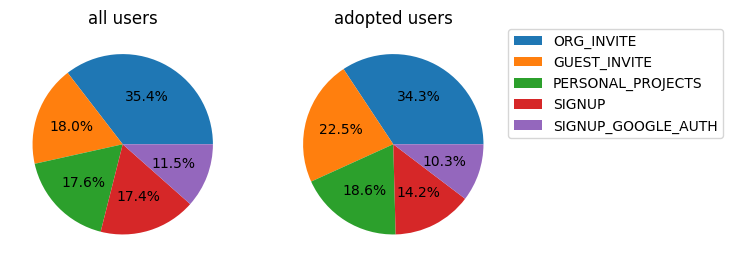

In [333]:
f, ax = plt.subplots(1, 2)
ax[0].pie(users['creation_source'].value_counts(), autopct='%1.1f%%')
ax[0].set_title('all users')
ax[1].pie(adopted_users['creation_source'].value_counts(), autopct='%1.1f%%')
ax[1].set_title('adopted users')

f.legend(users['creation_source'].value_counts().index, bbox_to_anchor=(1.25, 0.75))

Text(0.5, 0.98, 'orgs with more users/adopted users (top 10)')

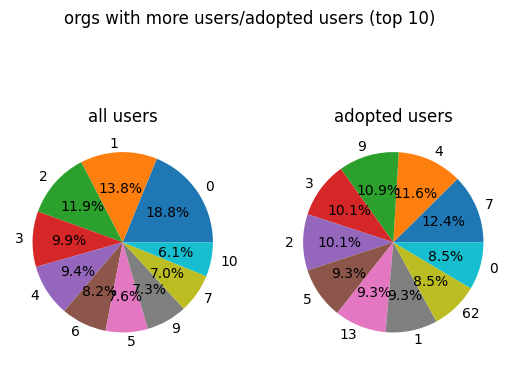

In [364]:
f, ax = plt.subplots(1, 2)
ax[0].pie(users['org_id'].value_counts().head(10), labels=users['org_id'].value_counts().head(10).index, autopct='%1.1f%%')
ax[0].set_title('all users')
ax[1].pie(adopted_users['org_id'].value_counts().head(10), labels=adopted_users['org_id'].value_counts().head(10).index, autopct='%1.1f%%')
ax[1].set_title('adopted users')

f.suptitle('orgs with more users/adopted users (top 10)')

In [380]:
users['invited_by_user_id'].value_counts().sort_values(ascending=False).head(10)

invited_by_user_id
10741.0    13
2527.0     12
1525.0     11
11770.0    11
2308.0     11
10481.0    10
4612.0     10
8068.0     10
2354.0     10
10628.0    10
Name: count, dtype: int64

5583

12000

0.46525

640

1481

0.43214044564483456

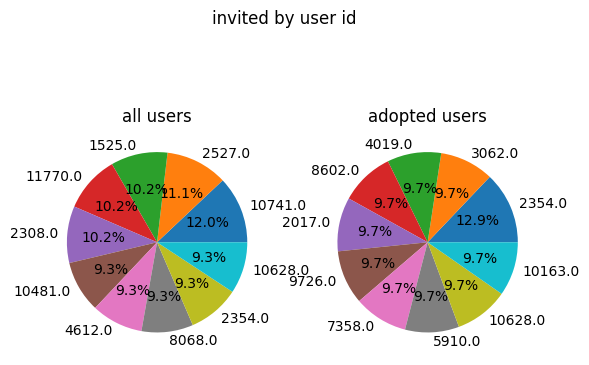

In [385]:
f, ax = plt.subplots(1, 2)
users_pie_plot = users['invited_by_user_id'].value_counts().sort_values(ascending=False).head(10)
adopted_users_pie_plot = adopted_users['invited_by_user_id'].value_counts().sort_values(ascending=False).head(10)
ax[0].pie(users_pie_plot, labels=users_pie_plot.index, autopct='%1.1f%%')
ax[0].set_title('all users')
ax[1].pie(adopted_users_pie_plot, labels=adopted_users_pie_plot.index, autopct='%1.1f%%')
ax[1].set_title('adopted users')

f.suptitle('invited by user id')

display(users['invited_by_user_id'].isna().sum(), len(users), users['invited_by_user_id'].isna().sum()/ len(users))
display(adopted_users['invited_by_user_id'].isna().sum(), len(adopted_users), adopted_users['invited_by_user_id'].isna().sum()/ len(adopted_users))

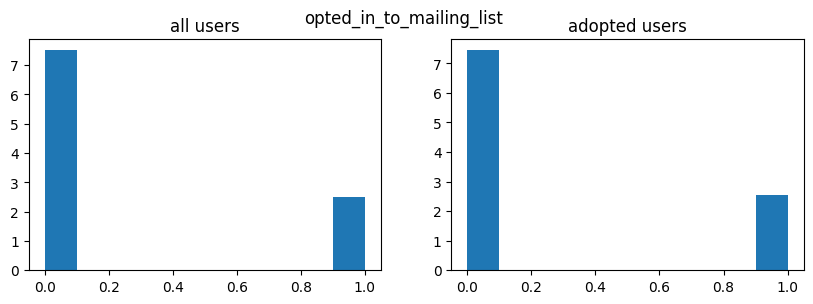

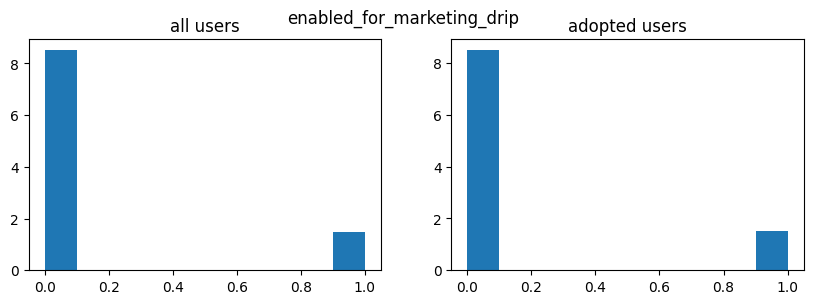

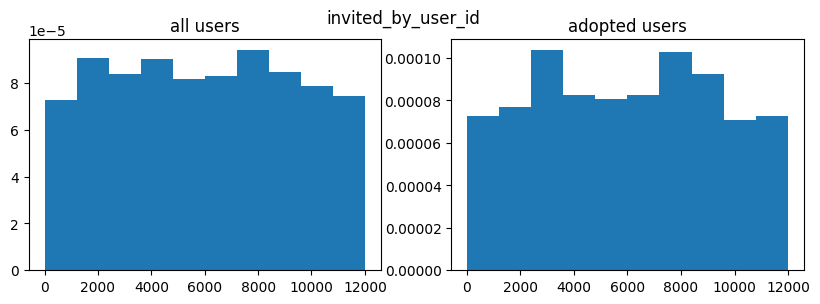

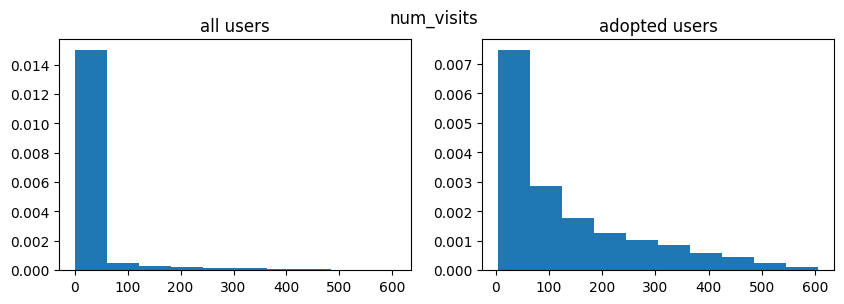

In [345]:
for n in ['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'invited_by_user_id', 'num_visits']:
    f, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax[0].hist(users[n], density=True)
    ax[1].hist(adopted_users[n], density=True)
    ax[0].set_title('all users')
    ax[1].set_title('adopted users')

    f.suptitle(n)